# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Time series libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Data

In [2]:
df = pd.read_csv("BRI_Preprocessed_Data", index_col='Date', parse_dates=True)
df.index.freq = 'D'

df.head()

,Open,High,Low,Volume,Adj Close,Close
Date,,,,,,
2016-01-04,2280.0,2320.0,2240.000000,10038.0,1935.290000,2295.00000
2016-01-05,2315.0,2365.0,2308.260259,10804.0,1952.160000,2315.00000
2016-01-06,2280.0,2355.0,2280.000000,10513.0,1943.730000,2305.00000
2016-01-07,2270.0,2305.0,2250.000000,7128.0,1897.350000,2250.00000
2016-01-08,2250.0,2340.0,2250.000000,1065.0,1955.074411,2313.15347


In [3]:
len(df)

2005

# 3. Open Stock Price

### - Plot

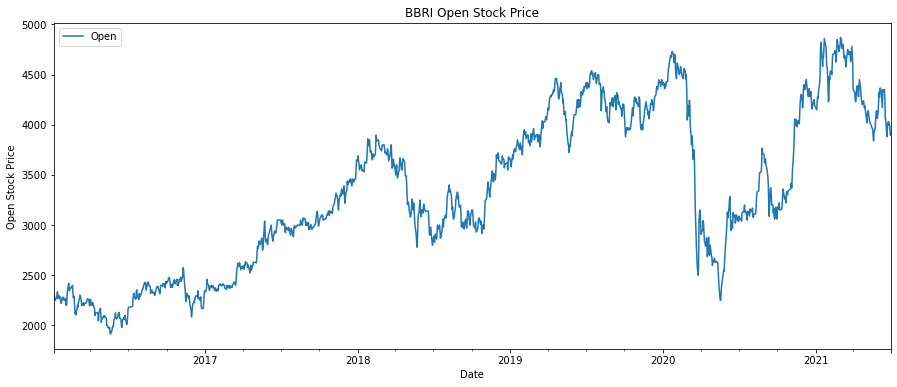

In [4]:
df[['Open']].plot(figsize=(15,6), title='BBRI Open Stock Price', ylabel='Open Stock Price');

### - Check Stationary Data

In [5]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
# Cek stationary data open stock price
adfuller_test(df['Open'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.776025
p-value                    0.392428
# lags used                2.000000
# observations          2002.000000
critical value (1%)       -3.433621
critical value (5%)       -2.862985
critical value (10%)      -2.567539

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationerm

### - Differencing

In [7]:
# differencing
df['Open d1'] = diff(df['Open'], k_diff=1)     #lag 1

# Cek stationary data open stock price dengan differencing lag 1
adfuller_test(df['Open d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -29.924139
p-value                    0.000000
# lags used                1.000000
# observations          2002.000000
critical value (1%)       -3.433621
critical value (5%)       -2.862985
critical value (10%)      -2.567539

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data open stock price akan digunakan parameter differencing ARIMA d=1. 

### - Seasonality Data

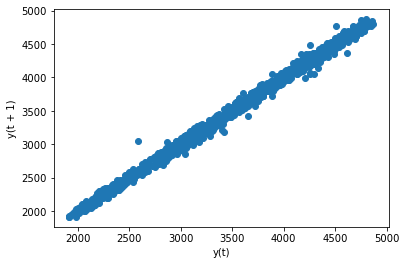

In [8]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Open']);

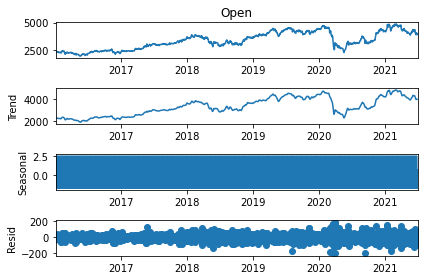

In [9]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Open'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

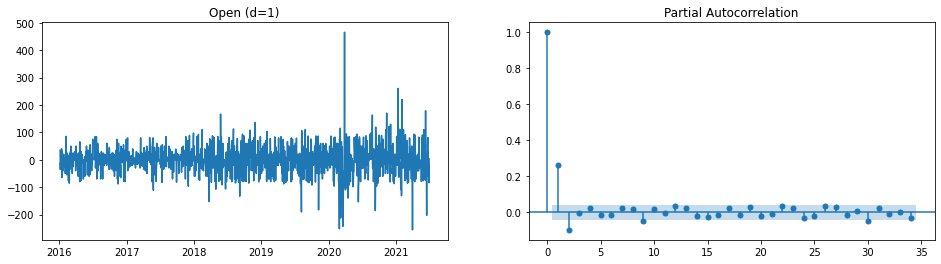

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_pacf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

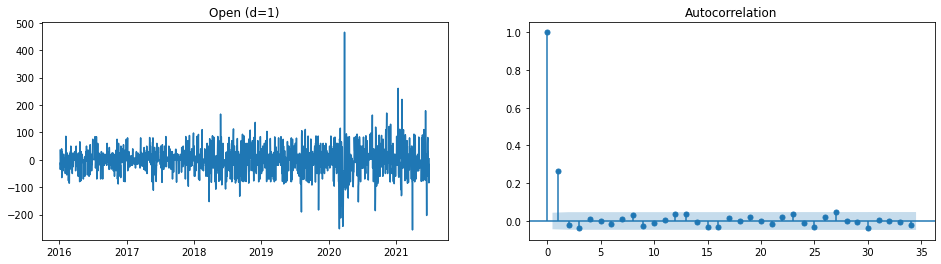

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_acf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 0

### - Split Data

In [12]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [13]:
ARIMA_open = ARIMA(train_data['Open'], order=(2,1,0)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1945
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -10107.843
Date:                Sun, 12 Dec 2021   AIC                          20221.686
Time:                        10:27:49   BIC                          20238.403
Sample:                    01-04-2016   HQIC                         20227.833
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2922      0.016     18.353      0.000       0.261       0.323
ar.L2         -0.1001      0.017     -5.791      0.000      -0.134      -0.066
sigma2      1922.3980     31.539     60.954      0.000    1860.584    1984.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4244.99
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               4.21   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [14]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,0) Test Prediction')
prediction_test

2021-05-02    4115.237462
2021-05-03    4116.849316
2021-05-04    4117.797220
2021-05-05    4117.912860
2021-05-06    4117.851748
2021-05-07    4117.822310
2021-05-08    4117.819825
2021-05-09    4117.822047
2021-05-10    4117.822945
2021-05-11    4117.822985
2021-05-12    4117.822906
2021-05-13    4117.822879
2021-05-14    4117.822879
2021-05-15    4117.822882
2021-05-16    4117.822883
2021-05-17    4117.822883
2021-05-18    4117.822883
2021-05-19    4117.822883
2021-05-20    4117.822883
2021-05-21    4117.822883
2021-05-22    4117.822883
2021-05-23    4117.822883
2021-05-24    4117.822883
2021-05-25    4117.822883
2021-05-26    4117.822883
2021-05-27    4117.822883
2021-05-28    4117.822883
2021-05-29    4117.822883
2021-05-30    4117.822883
2021-05-31    4117.822883
2021-06-01    4117.822883
2021-06-02    4117.822883
2021-06-03    4117.822883
2021-06-04    4117.822883
2021-06-05    4117.822883
2021-06-06    4117.822883
2021-06-07    4117.822883
2021-06-08    4117.822883
2021-06-09  

### - Model Evaluation

In [15]:
# rmse
error_rmse = rmse(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,0) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,0) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_open.aic
print(f'ARIMA(2,1,0) AIC: {aic_values:6.5}')

ARIMA(2,1,0) RMSE Error: 149.2210352
ARIMA(2,1,0) MAE Error: 128.1450694
ARIMA(2,1,0) AIC: 2.0222e+04


In [16]:
# perbandingan rata-rata open stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Open stock price actual:", test_data['Open'].mean())
print("Rata-rata Open stock price predicted:", prediction_test.mean())

Rata-rata Open stock price actual: 4090.67323732515
Rata-rata Open stock price predicted: 4117.765047841391


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [17]:
ARIMA_open = ARIMA(df['Open'], order=(2,1,0)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 2005
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -10439.470
Date:                Sun, 12 Dec 2021   AIC                          20884.939
Time:                        10:27:50   BIC                          20901.748
Sample:                    01-04-2016   HQIC                         20891.110
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2882      0.016     18.140      0.000       0.257       0.319
ar.L2         -0.0971      0.017     -5.653      0.000      -0.131      -0.063
sigma2      1960.5058     32.212     60.863      0.000    1897.372    2023.640
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4025.66
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict open stock price for the next 6 months

In [18]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,0) Open Stock Price Forecast')
forecast

2021-07-01    3909.269766
2021-07-02    3911.563428
2021-07-03    3911.323884
2021-07-04    3911.032031
2021-07-05    3910.971196
                 ...     
2021-12-25    3910.991879
2021-12-26    3910.991879
2021-12-27    3910.991879
2021-12-28    3910.991879
2021-12-29    3910.991879
Freq: D, Name: ARIMA(2,1,0) Open Stock Price Forecast, Length: 182, dtype: float64

In [19]:
# save model
ARIMA_open.save('model_bri_open.pkl')
# load model
# ARIMA_open = ARIMAResults.load('model_bni_open.pkl')

# 4. High Stock Price Model

### - Plot

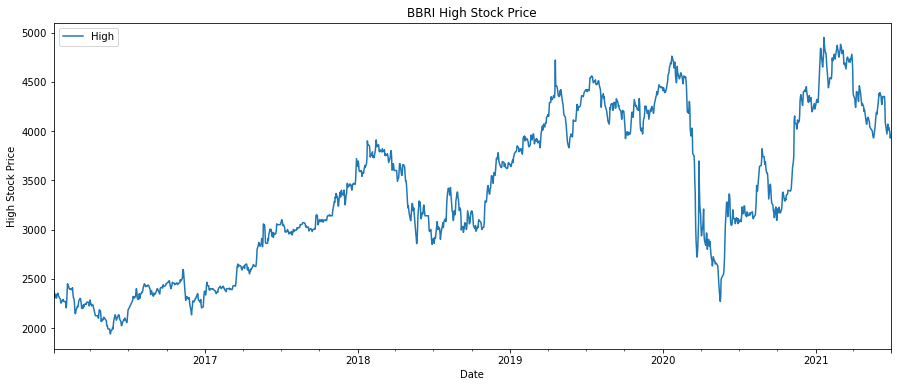

In [20]:
df[['High']].plot(figsize=(15,6), title='BBRI High Stock Price', ylabel='High Stock Price');

### - Check Stationary Data

In [21]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
# Cek stationary data high stock price
adfuller_test(df['High'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.768784
p-value                    0.396066
# lags used                2.000000
# observations          2002.000000
critical value (1%)       -3.433621
critical value (5%)       -2.862985
critical value (10%)      -2.567539

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [23]:
# differencing
df['High d1'] = diff(df['High'], k_diff=1)     #lag 1

# Cek stationary data high stock price dengan differencing lag 1
adfuller_test(df['High d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -28.021834
p-value                    0.000000
# lags used                1.000000
# observations          2002.000000
critical value (1%)       -3.433621
critical value (5%)       -2.862985
critical value (10%)      -2.567539

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data high stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

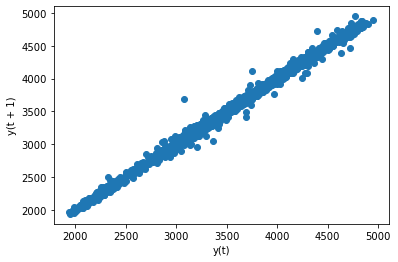

In [24]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['High']);

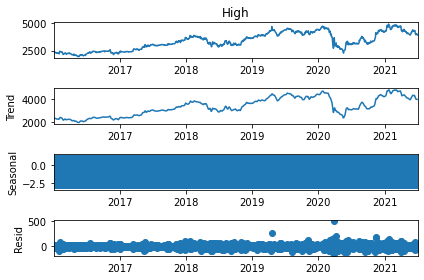

In [25]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['High'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data high stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

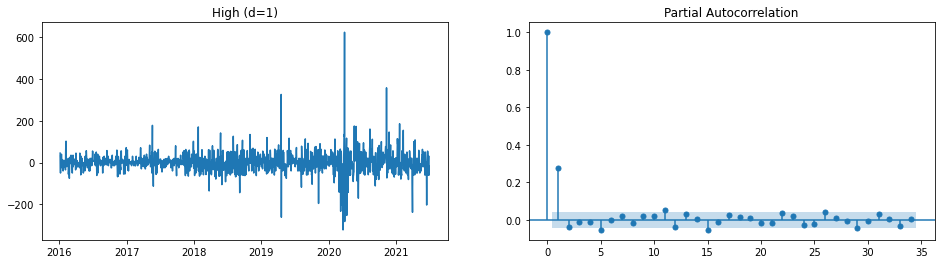

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_pacf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 1

### - Moving Average (MA) Parameter

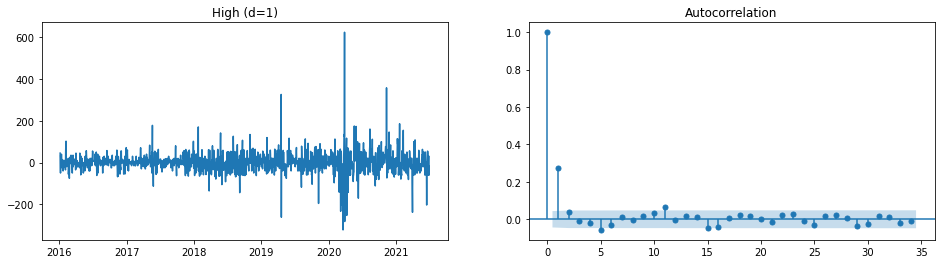

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_acf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [28]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [29]:
ARIMA_high = ARIMA(train_data['High'], order=(1,1,1)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1945
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10037.809
Date:                Sun, 12 Dec 2021   AIC                          20081.617
Time:                        10:27:54   BIC                          20098.335
Sample:                    01-04-2016   HQIC                         20087.764
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1466      0.058      2.516      0.012       0.032       0.261
ma.L1          0.1373      0.062      2.205      0.027       0.015       0.259
sigma2      1788.6284     15.488    115.485      0.000    1758.272    1818.984
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            100700.19
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.67   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [30]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Test Prediction')
prediction_test

2021-05-02    4122.915745
2021-05-03    4121.877293
2021-05-04    4121.725070
2021-05-05    4121.702757
2021-05-06    4121.699486
2021-05-07    4121.699006
2021-05-08    4121.698936
2021-05-09    4121.698926
2021-05-10    4121.698924
2021-05-11    4121.698924
2021-05-12    4121.698924
2021-05-13    4121.698924
2021-05-14    4121.698924
2021-05-15    4121.698924
2021-05-16    4121.698924
2021-05-17    4121.698924
2021-05-18    4121.698924
2021-05-19    4121.698924
2021-05-20    4121.698924
2021-05-21    4121.698924
2021-05-22    4121.698924
2021-05-23    4121.698924
2021-05-24    4121.698924
2021-05-25    4121.698924
2021-05-26    4121.698924
2021-05-27    4121.698924
2021-05-28    4121.698924
2021-05-29    4121.698924
2021-05-30    4121.698924
2021-05-31    4121.698924
2021-06-01    4121.698924
2021-06-02    4121.698924
2021-06-03    4121.698924
2021-06-04    4121.698924
2021-06-05    4121.698924
2021-06-06    4121.698924
2021-06-07    4121.698924
2021-06-08    4121.698924
2021-06-09  

### - Model Evaluation

In [31]:
# rmse
error_rmse = rmse(test_data['High'], prediction_test)
print(f'ARIMA(1,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['High'], prediction_test)
print(f'ARIMA(1,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_high.aic
print(f'ARIMA(1,1,1) AIC: {aic_values:6.5}')

ARIMA(1,1,1) RMSE Error: 145.6995472
ARIMA(1,1,1) MAE Error: 124.5593283
ARIMA(1,1,1) AIC: 2.0082e+04


In [32]:
# perbandingan rata-rata high stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata High stock price actual:", test_data['High'].mean())
print("Rata-rata High stock price predicted:", prediction_test.mean())

Rata-rata High stock price actual: 4133.343930636169
Rata-rata High stock price predicted: 4121.7226878943175


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [33]:
ARIMA_high = ARIMA(df['High'], order=(1,1,1)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 2005
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10343.052
Date:                Sun, 12 Dec 2021   AIC                          20692.104
Time:                        10:27:54   BIC                          20708.913
Sample:                    01-04-2016   HQIC                         20698.275
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1542      0.057      2.700      0.007       0.042       0.266
ma.L1          0.1317      0.061      2.156      0.031       0.012       0.251
sigma2      1780.4520     15.248    116.763      0.000    1750.566    1810.338
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            100502.92
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.67   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict high stock price for the next 6 months

In [34]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) High Stock Price Forecast')
forecast

2021-07-01    3968.753192
2021-07-02    3970.361358
2021-07-03    3970.609267
2021-07-04    3970.647483
2021-07-05    3970.653375
                 ...     
2021-12-25    3970.654448
2021-12-26    3970.654448
2021-12-27    3970.654448
2021-12-28    3970.654448
2021-12-29    3970.654448
Freq: D, Name: ARIMA(1,1,1) High Stock Price Forecast, Length: 182, dtype: float64

In [35]:
# save model
ARIMA_high.save('model_bri_high.pkl')

# 5. Low Stock Price Model

### - Plot

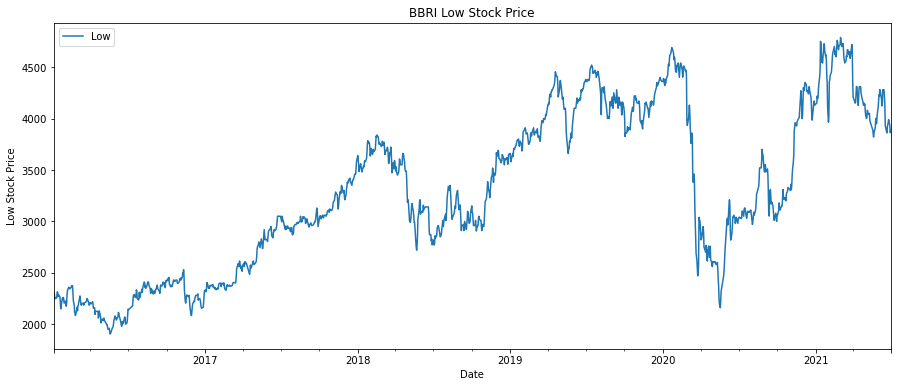

In [36]:
df[['Low']].plot(figsize=(15,6), title='BBRI Low Stock Price', ylabel='Low Stock Price');

### - Check Stationary Data

In [37]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [38]:
# Cek stationary data low stock price
adfuller_test(df['Low'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.790846
p-value                    0.385016
# lags used                3.000000
# observations          2001.000000
critical value (1%)       -3.433622
critical value (5%)       -2.862985
critical value (10%)      -2.567540

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [39]:
# differencing
df['Low d1'] = diff(df['Low'], k_diff=1)     #lag 1

# Cek stationary data low stock price dengan differencing lag 1
adfuller_test(df['Low d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -24.912605
p-value                    0.000000
# lags used                2.000000
# observations          2001.000000
critical value (1%)       -3.433622
critical value (5%)       -2.862985
critical value (10%)      -2.567540

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data low stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

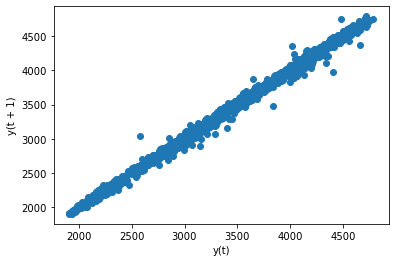

In [40]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Low']);

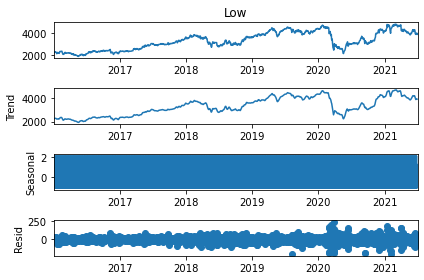

In [41]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Low'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data low stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter¶

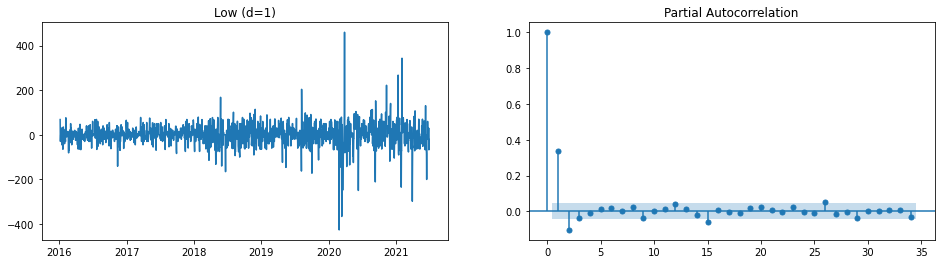

In [42]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_pacf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 3

### - Moving Average (MA) Parameter

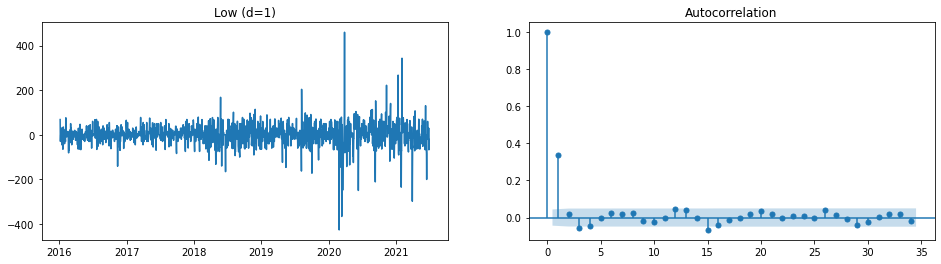

In [43]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_acf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [44]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [45]:
ARIMA_low = ARIMA(train_data['Low'], order=(3,1,1)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 1945
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -10004.608
Date:                Sun, 12 Dec 2021   AIC                          20019.216
Time:                        10:27:59   BIC                          20047.079
Sample:                    01-04-2016   HQIC                         20029.462
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4499      0.427      1.053      0.293      -0.388       1.288
ar.L2         -0.1233      0.163     -0.755      0.450      -0.443       0.197
ar.L3         -0.0305      0.059     -0.516      0.606      -0.146       0.085
ma.L1         -0.0800      0.428     -0.187      0.852      -0.920       0.760
sigma2      1728.6858     19.167     90.192      0.000    1691.120    1766.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26517.41
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.70   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [46]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,1) Test Prediction')
prediction_test

2021-05-02    4022.509655
2021-05-03    4024.994474
2021-05-04    4028.795090
2021-05-05    4030.528905
2021-05-06    4030.764675
2021-05-07    4030.541090
2021-05-08    4030.358545
2021-05-09    4030.296784
2021-05-10    4030.298320
2021-05-11    4030.312192
2021-05-12    4030.320128
2021-05-13    4030.321942
2021-05-14    4030.321357
2021-05-15    4030.320628
2021-05-16    4030.320316
2021-05-17    4030.320284
2021-05-18    4030.320330
2021-05-19    4030.320364
2021-05-20    4030.320375
2021-05-21    4030.320374
2021-05-22    4030.320372
2021-05-23    4030.320370
2021-05-24    4030.320370
2021-05-25    4030.320370
2021-05-26    4030.320370
2021-05-27    4030.320370
2021-05-28    4030.320370
2021-05-29    4030.320370
2021-05-30    4030.320370
2021-05-31    4030.320370
2021-06-01    4030.320370
2021-06-02    4030.320370
2021-06-03    4030.320370
2021-06-04    4030.320370
2021-06-05    4030.320370
2021-06-06    4030.320370
2021-06-07    4030.320370
2021-06-08    4030.320370
2021-06-09  

### - Model Evaluation

In [47]:
# rmse
error_rmse = rmse(test_data['Low'], prediction_test)
print(f'ARIMA(3,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Low'], prediction_test)
print(f'ARIMA(3,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_low.aic
print(f'ARIMA(3,1,1) AIC: {aic_values:6.5}')

ARIMA(3,1,1) RMSE Error: 134.7509176
ARIMA(3,1,1) MAE Error: 114.4288606
ARIMA(3,1,1) AIC: 2.0019e+04


In [48]:
# perbandingan rata-rata low stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Low stock price actual:", test_data['Low'].mean())
print("Rata-rata Low stock price predicted:", prediction_test.mean())

Rata-rata Low stock price actual: 4027.32536426498
Rata-rata Low stock price predicted: 4030.090343963032


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [49]:
ARIMA_low = ARIMA(df['Low'], order=(3,1,1)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 2005
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -10317.886
Date:                Sun, 12 Dec 2021   AIC                          20645.773
Time:                        10:28:00   BIC                          20673.787
Sample:                    01-04-2016   HQIC                         20656.058
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5170      0.457      1.132      0.258      -0.378       1.412
ar.L2         -0.1463      0.175     -0.838      0.402      -0.488       0.196
ar.L3         -0.0197      0.062     -0.318      0.750      -0.141       0.102
ma.L1         -0.1478      0.457     -0.323      0.747      -1.044       0.749
sigma2      1736.6434     19.256     90.186      0.000    1698.902    1774.385
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             25682.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.61   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict low stock price for the next 6 months

In [50]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,1) Low Stock Price Forecast')
forecast

2021-07-01    3907.149215
2021-07-02    3913.315230
2021-07-03    3913.450079
2021-07-04    3912.279340
2021-07-05    3911.532694
                 ...     
2021-12-25    3911.424347
2021-12-26    3911.424347
2021-12-27    3911.424347
2021-12-28    3911.424347
2021-12-29    3911.424347
Freq: D, Name: ARIMA(3,1,1) Low Stock Price Forecast, Length: 182, dtype: float64

In [51]:
# save model
ARIMA_low.save('model_bri_low.pkl')

# 6. Stock Volume Model

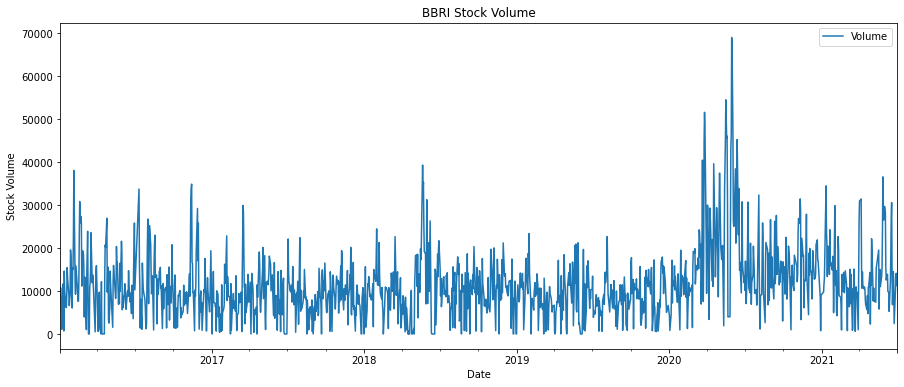

In [52]:
df[['Volume']].plot(figsize=(15,6), title='BBRI Stock Volume', ylabel='Stock Volume');

### - Check Stationarity Data

In [53]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [54]:
# Cek stationary data stock volume
adfuller_test(df['Volume'])

Augmented Dickey-Fuller Test:
ADF test statistic     -6.571699e+00
p-value                 7.906497e-09
# lags used             1.200000e+01
# observations          1.992000e+03
critical value (1%)    -3.433637e+00
critical value (5%)    -2.862992e+00
critical value (10%)   -2.567543e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data stock volume sudah stationer, maka tidak perlu dilakukan differencing. Dari informasi ini, untuk data volume stock akan digunakan parameter differencing ARIMA d=0

### - Seasonality Data

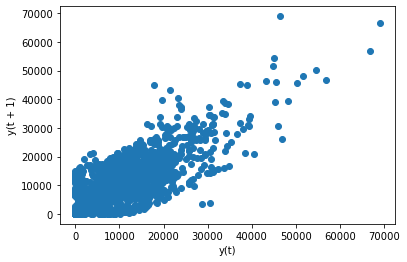

In [55]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Volume']);

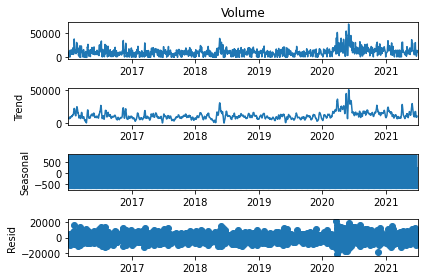

In [56]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Volume'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

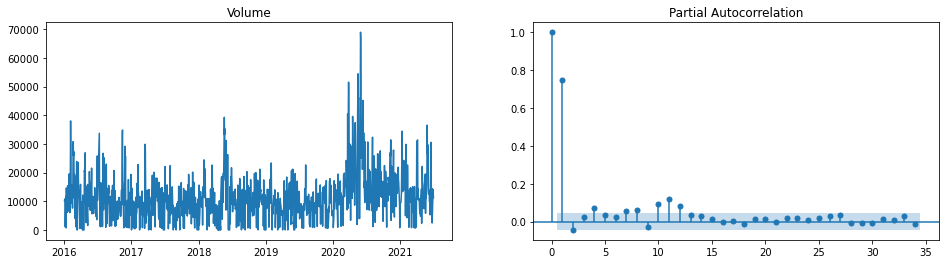

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_pacf(df['Volume'].dropna(), ax=ax2);

### - Moving Avarage (MA) Parameter

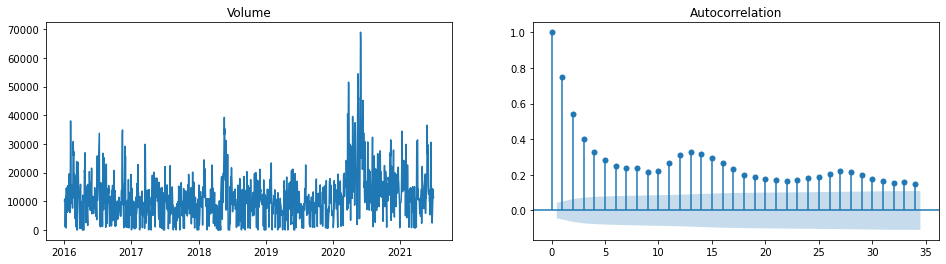

In [58]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_acf(df['Volume'].dropna(), ax=ax2);

Jika PACF dari deret yang berbeda menampilkan cutoff yang tajam atau autokorelasi lag-1 positif, sedangkan ACF meluruh lebih lambat, maka pertimbangkan untuk menambahkan suku AR ke model. Artinya pola autokorelasi dapat dijelaskan lebih mudah dengan menambahkan suku AR daripada menambahkan suku MA. Jeda di mana PACF terputus menunjukkan jumlah istilah AR. Karena AR menunjukkan autokorelasi lag-1 positif, maka akan digunakan p = 1, q = 0. 

### - Split Data

In [59]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [60]:
ARIMA_volume = ARIMA(train_data['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 1945
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -19359.241
Date:                Sun, 12 Dec 2021   AIC                          38724.482
Time:                        10:28:04   BIC                          38741.201
Sample:                    01-04-2016   HQIC                         38730.630
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.118e+04    484.639     23.076      0.000    1.02e+04    1.21e+04
ar.L1          0.7473      0.010     72.766      0.000       0.727       0.767
sigma2      2.588e+07      0.085   3.06e+08      0.000    2.59e+07    2.59e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):               535.77
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.76e+23. Standard errors may be unstable.
"""

### - Predictions in Test Data

In [61]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Test Prediction')
prediction_test

2021-05-02    17301.252064
2021-05-03    15755.293240
2021-05-04    14600.010548
2021-05-05    13736.677011
2021-05-06    13091.514748
2021-05-07    12609.390137
2021-05-08    12249.102263
2021-05-09    11979.862010
2021-05-10    11778.660917
2021-05-11    11628.304946
2021-05-12    11515.945129
2021-05-13    11431.979534
2021-05-14    11369.232715
2021-05-15    11322.342518
2021-05-16    11287.301847
2021-05-17    11261.116234
2021-05-18    11241.547934
2021-05-19    11226.924700
2021-05-20    11215.996874
2021-05-21    11207.830597
2021-05-22    11201.728003
2021-05-23    11197.167583
2021-05-24    11193.759618
2021-05-25    11191.212872
2021-05-26    11189.309710
2021-05-27    11187.887492
2021-05-28    11186.824680
2021-05-29    11186.030449
2021-05-30    11185.436926
2021-05-31    11184.993391
2021-06-01    11184.661941
2021-06-02    11184.414252
2021-06-03    11184.229155
2021-06-04    11184.090834
2021-06-05    11183.987467
2021-06-06    11183.910222
2021-06-07    11183.852498
2

### - Model Evaluation

In [62]:
# rmse
error_rmse = rmse(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_volume.aic
print(f'ARIMA(1,0,0) AIC: {aic_values:6.5}')

ARIMA(1,0,0) RMSE Error:  8217.58875
ARIMA(1,0,0) MAE Error: 5825.528372
ARIMA(1,0,0) AIC: 3.8724e+04


In [63]:
# perbandingan rata-rata stock volume 2 bulan kedepan antara predicted dan actual
print("Rata-rata stock Volume actual:", test_data['Volume'].mean())
print("Rata-rata stock Volume predicted:", prediction_test.mean())

Rata-rata stock Volume actual: 14547.032515898069
Rata-rata stock Volume predicted: 11587.1494764467


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [64]:
ARIMA_volume = ARIMA(df['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 2005
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -19953.199
Date:                Sun, 12 Dec 2021   AIC                          39912.398
Time:                        10:28:04   BIC                          39929.208
Sample:                    01-04-2016   HQIC                         39918.570
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.128e+04    480.605     23.479      0.000    1.03e+04    1.22e+04
ar.L1          0.7491      0.010     73.607      0.000       0.729       0.769
sigma2      2.579e+07      0.082   3.16e+08      0.000    2.58e+07    2.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):               533.06
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.4e+23. Standard errors may be unstable.
"""

### - Forecasting The Future Value
Predict stock volume price for the next 6 months

In [65]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Stock Volume Forecast')
forecast

2021-07-01    11284.832077
2021-07-02    11284.706285
2021-07-03    11284.612053
2021-07-04    11284.541464
2021-07-05    11284.488584
                  ...     
2021-12-25    11284.330698
2021-12-26    11284.330698
2021-12-27    11284.330698
2021-12-28    11284.330698
2021-12-29    11284.330698
Freq: D, Name: ARIMA(1,0,0) Stock Volume Forecast, Length: 182, dtype: float64

In [66]:
# save model
ARIMA_volume.save('model_bri_volume.pkl')

# 7. Adj. Close Stock Price Model

### - Plot

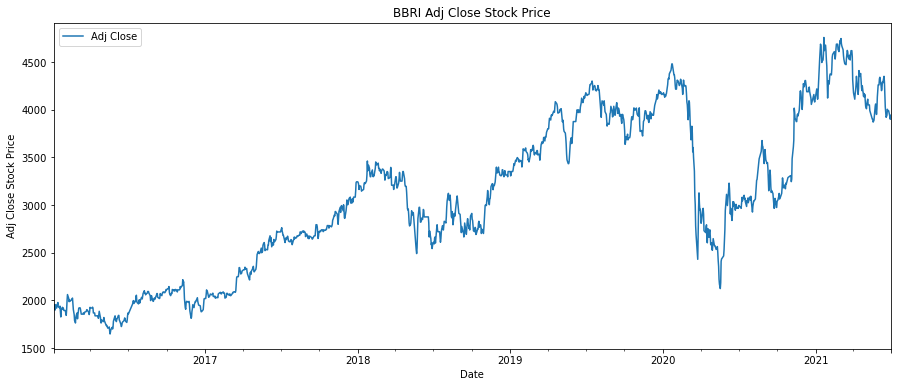

In [67]:
df[['Adj Close']].plot(figsize=(15,6), title='BBRI Adj Close Stock Price', ylabel='Adj Close Stock Price');

### - Check Stationarity Data

In [68]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [69]:
# Cek stationary data adj close stock price
adfuller_test(df['Adj Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.588993
p-value                    0.489121
# lags used                7.000000
# observations          1997.000000
critical value (1%)       -3.433629
critical value (5%)       -2.862988
critical value (10%)      -2.567541

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [70]:
# differencing
df['Adj Close d1'] = diff(df['Adj Close'], k_diff=1)     #lag 1

# Cek stationary data adj close stock price dengan differencing lag 1
adfuller_test(df['Adj Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.652695e+01
p-value                 2.039983e-29
# lags used             6.000000e+00
# observations          1.997000e+03
critical value (1%)    -3.433629e+00
critical value (5%)    -2.862988e+00
critical value (10%)   -2.567541e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data adj close stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

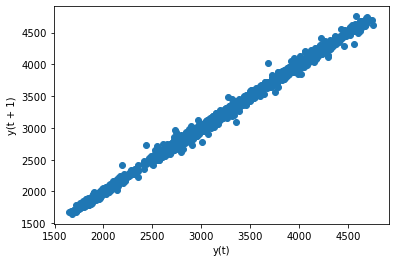

In [71]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Adj Close']);

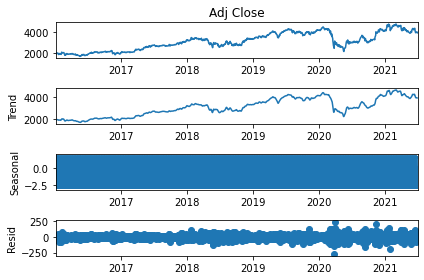

In [72]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Adj Close'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

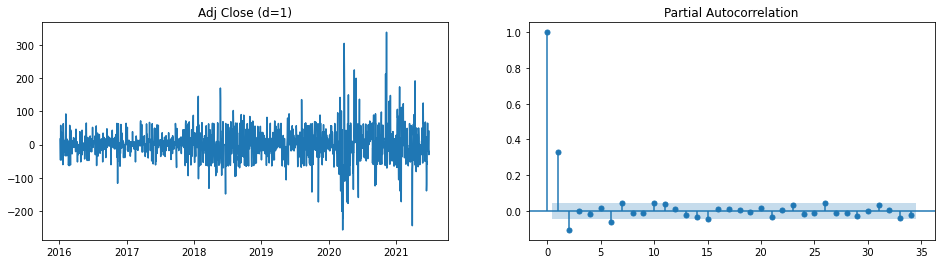

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_pacf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

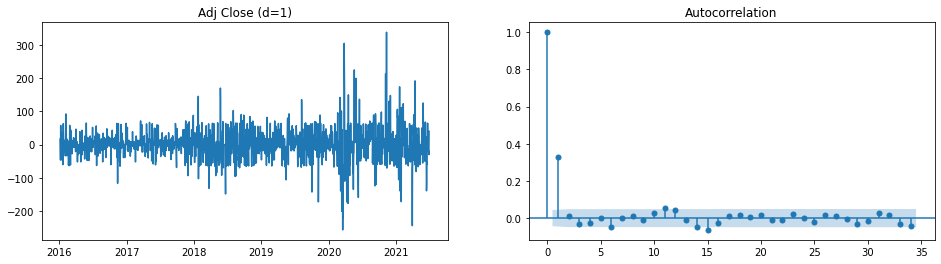

In [74]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_acf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [75]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [76]:
ARIMA_adjclose = ARIMA(train_data['Adj Close'], order=(2,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1945
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9915.836
Date:                Sun, 12 Dec 2021   AIC                          19839.671
Time:                        10:28:07   BIC                          19861.961
Sample:                    01-04-2016   HQIC                         19847.868
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2791      0.183      1.527      0.127      -0.079       0.637
ar.L2         -0.0817      0.059     -1.386      0.166      -0.197       0.034
ma.L1          0.0760      0.183      0.414      0.679      -0.284       0.436
sigma2      1577.0507     22.740     69.351      0.000    1532.481    1621.620
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5120.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.70   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [77]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-02    4019.549065
2021-05-03    4020.193530
2021-05-04    4021.771222
2021-05-05    4022.158927
2021-05-06    4022.138300
2021-05-07    4022.100883
2021-05-08    4022.092125
2021-05-09    4022.092736
2021-05-10    4022.093621
2021-05-11    4022.093819
2021-05-12    4022.093801
2021-05-13    4022.093780
2021-05-14    4022.093776
2021-05-15    4022.093776
2021-05-16    4022.093777
2021-05-17    4022.093777
2021-05-18    4022.093777
2021-05-19    4022.093777
2021-05-20    4022.093777
2021-05-21    4022.093777
2021-05-22    4022.093777
2021-05-23    4022.093777
2021-05-24    4022.093777
2021-05-25    4022.093777
2021-05-26    4022.093777
2021-05-27    4022.093777
2021-05-28    4022.093777
2021-05-29    4022.093777
2021-05-30    4022.093777
2021-05-31    4022.093777
2021-06-01    4022.093777
2021-06-02    4022.093777
2021-06-03    4022.093777
2021-06-04    4022.093777
2021-06-05    4022.093777
2021-06-06    4022.093777
2021-06-07    4022.093777
2021-06-08    4022.093777
2021-06-09  

### - Model Evaluation

In [78]:
# rmse
error_rmse = rmse(test_data['Adj Close'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Adj Close'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_adjclose.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 153.1179901
ARIMA(2,1,1) MAE Error: 119.1432457
ARIMA(2,1,1) AIC: 1.984e+04


In [79]:
# perbandingan rata-rata adjusted close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Adjusted Close stock price actual:", test_data['Adj Close'].mean())
print("Rata-rata Adjusted Close stock price predicted:", prediction_test.mean())

Rata-rata Adjusted Close stock price actual: 4068.7265492972333
Rata-rata Adjusted Close stock price predicted: 4022.016218452453


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [80]:
ARIMA_adjclose = ARIMA(df['Adj Close'], order=(2,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2005
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10221.299
Date:                Sun, 12 Dec 2021   AIC                          20450.599
Time:                        10:28:07   BIC                          20473.010
Sample:                    01-04-2016   HQIC                         20458.827
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3500      0.183      1.912      0.056      -0.009       0.709
ar.L2         -0.1025      0.060     -1.713      0.087      -0.220       0.015
ma.L1          0.0123      0.184      0.067      0.947      -0.349       0.373
sigma2      1575.8670     22.621     69.664      0.000    1531.531    1620.203
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4984.79
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.70   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict Adj Close stock price for the next 6 months

In [81]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Adj Close Stock Price Forecast')
forecast

2021-07-01    3957.677056
2021-07-02    3959.763674
2021-07-03    3958.681899
2021-07-04    3958.089368
2021-07-05    3957.992872
                 ...     
2021-12-25    3958.041855
2021-12-26    3958.041855
2021-12-27    3958.041855
2021-12-28    3958.041855
2021-12-29    3958.041855
Freq: D, Name: ARIMA(2,1,1) Adj Close Stock Price Forecast, Length: 182, dtype: float64

In [82]:
# save model
ARIMA_adjclose.save('model_bri_adjclose.pkl')

# 8. Close Stock Price Model

### - Plot

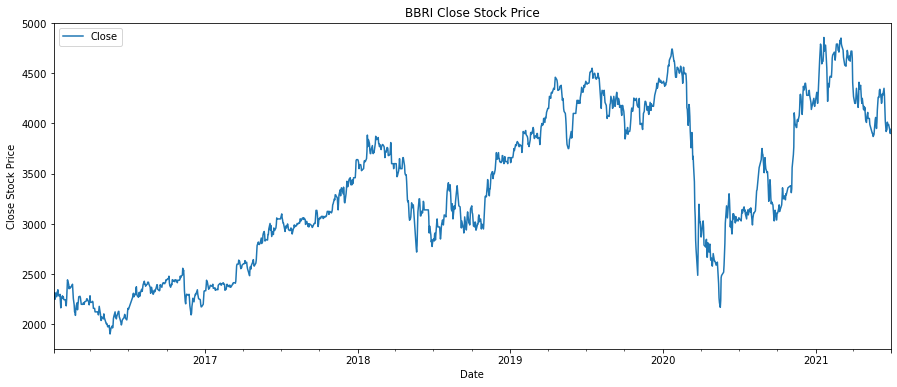

In [83]:
df[['Close']].plot(figsize=(15,6), title='BBRI Close Stock Price', ylabel='Close Stock Price');

### - Check Stationarity Data

In [84]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [85]:
# Cek stationary data close stock price
adfuller_test(df['Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.792268
p-value                    0.384307
# lags used                7.000000
# observations          1997.000000
critical value (1%)       -3.433629
critical value (5%)       -2.862988
critical value (10%)      -2.567541

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

In [86]:
# differencing
df['Close d1'] = diff(df['Close'], k_diff=1)     #lag 1

# Cek stationary data close stock price dengan differencing lag 1
adfuller_test(df['Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.645577e+01
p-value                 2.355289e-29
# lags used             6.000000e+00
# observations          1.997000e+03
critical value (1%)    -3.433629e+00
critical value (5%)    -2.862988e+00
critical value (10%)   -2.567541e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data close stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

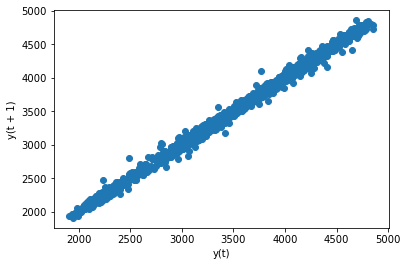

In [87]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Close']);

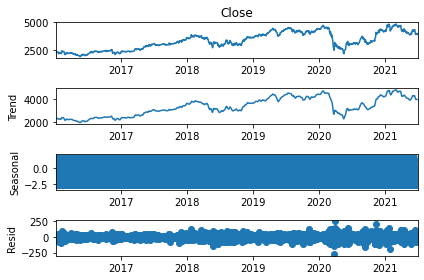

In [88]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Close'].dropna(), model='additive')
result.plot();

### - Autoregression (AR) Parameter

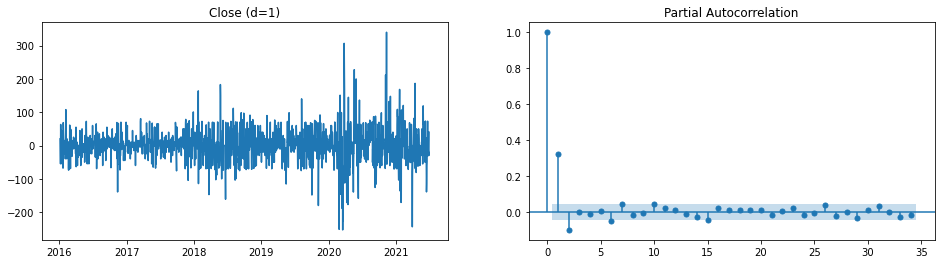

In [89]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_pacf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2 

### - Moving Average (MA) Parameter

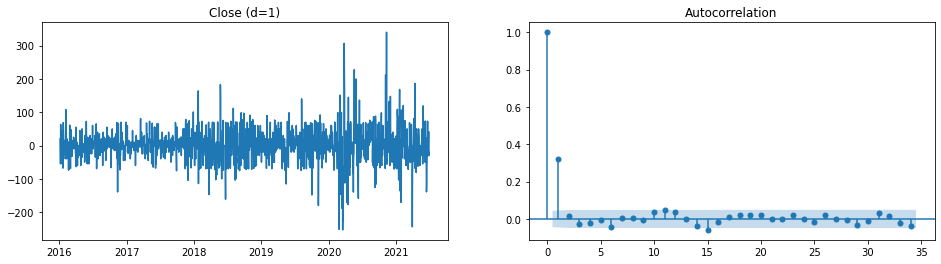

In [90]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_acf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1

### - Split Data

In [91]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [92]:
ARIMA_close = ARIMA(train_data['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1945
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10027.079
Date:                Sun, 12 Dec 2021   AIC                          20062.157
Time:                        10:28:11   BIC                          20084.447
Sample:                    01-04-2016   HQIC                         20070.353
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3328      0.210      1.588      0.112      -0.078       0.744
ar.L2         -0.0944      0.066     -1.425      0.154      -0.224       0.035
ma.L1          0.0172      0.211      0.082      0.935      -0.396       0.430
sigma2      1767.3547     27.706     63.791      0.000    1713.053    1821.657
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3406.63
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [93]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-02    4021.595470
2021-05-03    4022.346107
2021-05-04    4024.018969
2021-05-05    4024.504874
2021-05-06    4024.508645
2021-05-07    4024.464021
2021-05-08    4024.448813
2021-05-09    4024.447965
2021-05-10    4024.449118
2021-05-11    4024.449582
2021-05-12    4024.449628
2021-05-13    4024.449599
2021-05-14    4024.449585
2021-05-15    4024.449583
2021-05-16    4024.449584
2021-05-17    4024.449584
2021-05-18    4024.449584
2021-05-19    4024.449584
2021-05-20    4024.449584
2021-05-21    4024.449584
2021-05-22    4024.449584
2021-05-23    4024.449584
2021-05-24    4024.449584
2021-05-25    4024.449584
2021-05-26    4024.449584
2021-05-27    4024.449584
2021-05-28    4024.449584
2021-05-29    4024.449584
2021-05-30    4024.449584
2021-05-31    4024.449584
2021-06-01    4024.449584
2021-06-02    4024.449584
2021-06-03    4024.449584
2021-06-04    4024.449584
2021-06-05    4024.449584
2021-06-06    4024.449584
2021-06-07    4024.449584
2021-06-08    4024.449584
2021-06-09  

### - Model Evaluation

In [94]:
# rmse
error_rmse = rmse(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_close.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 152.6015717
ARIMA(2,1,1) MAE Error: 119.1633518
ARIMA(2,1,1) AIC: 2.0062e+04


In [95]:
# perbandingan rata-rata close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Close stock price actual:", test_data['Close'].mean())
print("Rata-rata Close stock price predicted:", prediction_test.mean())

Rata-rata Close stock price actual: 4068.728639986087
Rata-rata Close stock price predicted: 4024.3618807327875


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [96]:
ARIMA_close = ARIMA(df['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2005
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10333.951
Date:                Sun, 12 Dec 2021   AIC                          20675.902
Time:                        10:28:12   BIC                          20698.313
Sample:                    01-04-2016   HQIC                         20684.130
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3747      0.207      1.808      0.071      -0.031       0.781
ar.L2         -0.1060      0.066     -1.595      0.111      -0.236       0.024
ma.L1         -0.0187      0.209     -0.090      0.928      -0.428       0.390
sigma2      1762.7621     27.483     64.140      0.000    1708.896    1816.628
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3330.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.63   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict close stock price for the next 6 months

In [97]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Open Stock Price Forecast')
forecast

2021-07-01    3957.256238
2021-07-02    3959.481873
2021-07-03    3958.486660
2021-07-04    3957.877867
2021-07-05    3957.755256
                 ...     
2021-12-25    3957.798447
2021-12-26    3957.798447
2021-12-27    3957.798447
2021-12-28    3957.798447
2021-12-29    3957.798447
Freq: D, Name: ARIMA(2,1,1) Open Stock Price Forecast, Length: 182, dtype: float64

In [98]:
# save model
ARIMA_close.save('model_bri_close.pkl')